# Итоговый проект по распознаванию сердечно-сосудистых заболеваний
Используем библиотеку Pytorch

In [1]:
import pandas as pd
from missingno import matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.optim as optim

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Информация о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Описательные статистики

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


Преобразуем данные датасета

In [5]:
target_data = df['cardio']
df = df.drop(columns = ['id', 'cardio'])

Визуализация пропусков датасета

<Axes: >

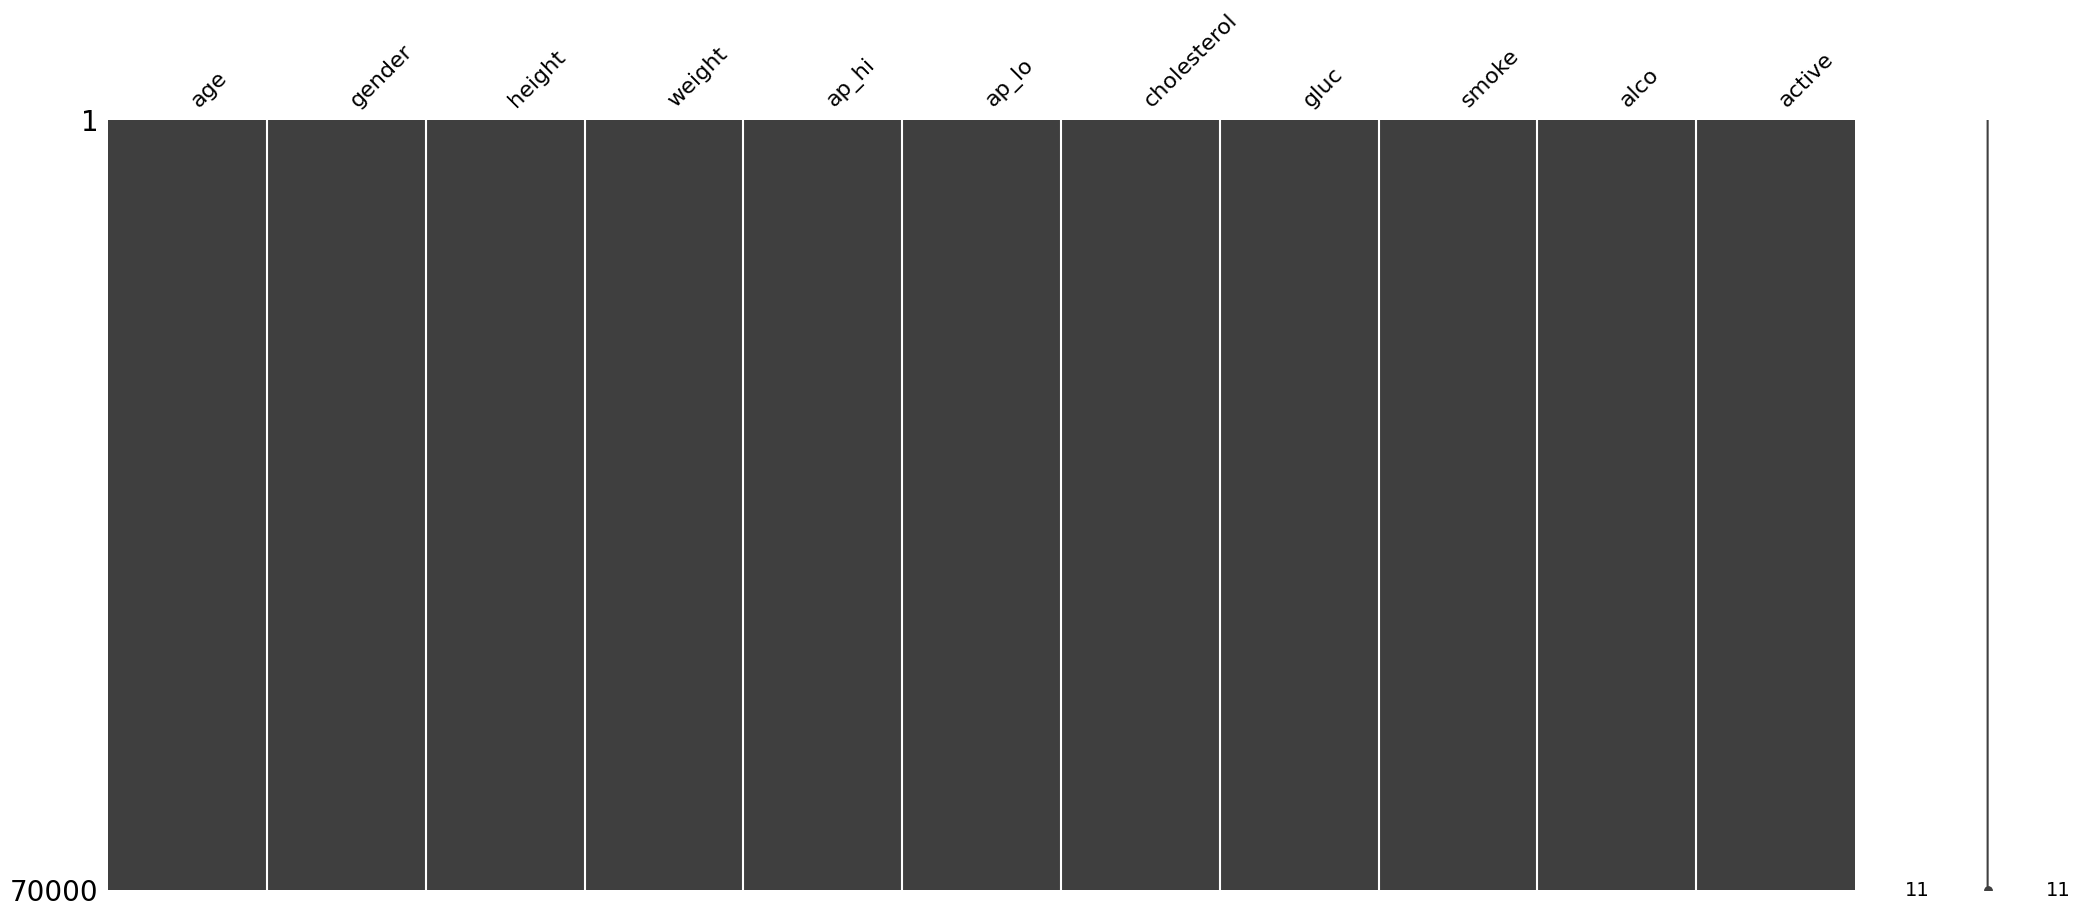

In [6]:
matrix(df)

Избавимся от выбросов с помощью межквартильного интервала

In [7]:
binary_columns = df.columns[df.isin([0, 1]).all()]
df_check = df.drop(columns=binary_columns)

Q1 = df_check.quantile(0.25)
Q3 = df_check.quantile(0.75)

df = df.drop(columns=df_check)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

column_to_check = df_check[(df_check >= lower_bound) & (df_check <= upper_bound)]
df = pd.concat([column_to_check, df], axis=1)

Избавимся от пропусков в датасете

In [8]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df_filled_original = scaler.inverse_transform(df_filled)
df = pd.DataFrame(df_filled_original, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  float64
 2   height       70000 non-null  float64
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  float64
 5   ap_lo        70000 non-null  float64
 6   cholesterol  70000 non-null  float64
 7   gluc         70000 non-null  float64
 8   smoke        70000 non-null  float64
 9   alco         70000 non-null  float64
 10  active       70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


Выполним нормализацию и стандартизацию данных

In [9]:
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

normalized_data = minmax_scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

standard_data = standard_scaler.fit_transform(df)
df = pd.DataFrame(standard_data, columns=df.columns)

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.436398,1.364055,0.470154,-0.905920,-1.062436,-0.251989,-0.539322,0.0,-0.310879,-0.238384,0.494167
1,0.307602,-0.733108,-1.105485,0.953922,0.889390,1.029498,2.400793,0.0,-0.310879,-0.238384,0.494167
2,-0.248270,-0.733108,0.076244,-0.744195,0.238781,-1.533476,2.400793,0.0,-0.310879,-0.238384,-2.023607
3,-0.748595,1.364055,0.601457,0.711334,1.539999,2.310984,-0.539322,0.0,-0.310879,-0.238384,0.494167
4,-0.809007,-0.733108,-1.105485,-1.391096,-1.713045,-1.097770,-0.539322,0.0,-0.310879,-0.238384,-2.023607


Подготовка данных к обучению

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.values, target_data.values, test_size=0.3)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Создание модели классификации

In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.l2_reg = 0.01
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x
    
    def l2_regulation(self):
        l2_reg = torch.tensor(0.)
        for param in self.parameters():
            l2_reg += torch.norm(param, 2)
        return self.l2_reg * l2_reg
    
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 5

best_loss = float('inf')
counter = 0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs, labels) + model.l2_regulation()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels) + model.l2_regulation()
            val_loss += loss.item()
            
    val_loss /= len(test_loader)
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break
   
model.load_state_dict(best_model_wts)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy}')

Epoch 1, Loss: 0.6618560287838816, Val Loss: 0.6398090566402157
Epoch 2, Loss: 0.6371153354566963, Val Loss: 0.6368555424783147
Epoch 3, Loss: 0.6359408629703148, Val Loss: 0.6374368268423791
Epoch 4, Loss: 0.6359299013376547, Val Loss: 0.6391326799603176
Epoch 5, Loss: 0.6358029806777329, Val Loss: 0.6369573458053931
Epoch 6, Loss: 0.6360022741766262, Val Loss: 0.6376341317795908
Epoch 7, Loss: 0.6358016870974249, Val Loss: 0.6375941333886876
Early stopping
Accuracy: 0.7261904761904762
